# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 46

**Author 1 (sciper):** Pierre-Jean Martin (258890)  
**Author 2 (sciper):** Louis Rostaing (257238)   
**Author 3 (sciper):** Yanis Bouadi (283606)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

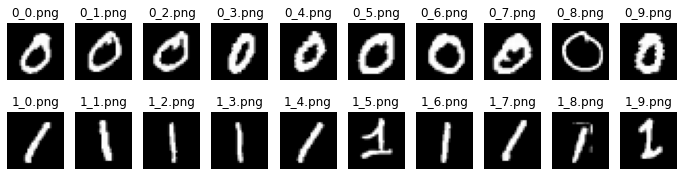

In [11]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [12]:
#importing libraries

from skimage import measure
import numpy as np
from scipy.fftpack import fft2, fft, ifft2


In [13]:
#This function returns a list with the complex coordinates of the contour 
#The input 'image' has to be a 28*28 array : ex: ones_im[0] or ones_im[1]

def Get_Contour_Coordinates(image):
    
    cont=measure.find_contours(image,70) # 70 corresponds to the grey value from which we start detecting the contour
    coordinates=[] 
    
    for k in range(len(cont[0])):

        x_k=cont[0][k][0]
        y_k=cont[0][k][1]
        z=[x_k,y_k]
        coordinates.append(z)
    
    coordinates = np.array(coordinates)
    
    return coordinates



In [14]:
#This function gives the Fourier Descriptors f_1 and f_2 of the contour

def Fourrier_Descriptors(picture):
    
    coordinates= Get_Contour_Coordinates(picture)    
    Fourier_descriptor= fft2(coordinates)
    A=[abs(Fourier_descriptor[1])[0]/abs(Fourier_descriptor[0])[0],abs(Fourier_descriptor[2])[0]/abs(Fourier_descriptor[0])[0]]
   
    return A
    

In [15]:
#This function returns the Fourier Descriptors for a set of images

def Get_Data(image):
    
    data=[]
    
    for img in image:
        data.append(Fourrier_Descriptors(img))
        
    return data


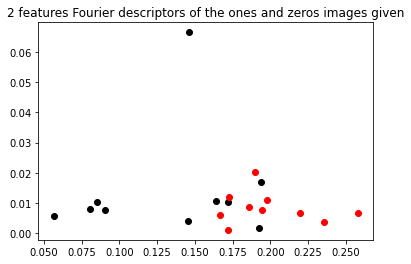

In [16]:
#Here, we are associating each image to a point: 20 images --> 20 points 
#The goal is to see if a classification can be pointed out from a plot

Coordinates_zeros=Get_Data(zeros_im)
Coordinates_ones=Get_Data(ones_im)

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]

plt.scatter(X_ones,Y_ones, color='black')
plt.scatter(X_zeros,Y_zeros, color='red')
plt.title('2 features Fourier descriptors of the ones and zeros images given')
plt.show()

### 1.3 Additional method (5 pts)

In [8]:
# Add your implementation and discussion

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

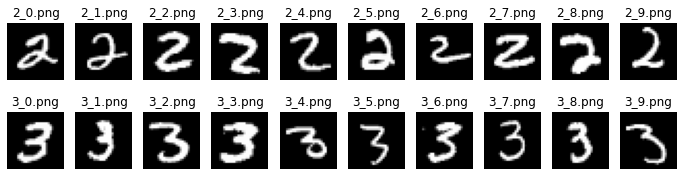

In [9]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [10]:
# Add your implementation and discussion